<a href="https://colab.research.google.com/github/elliemci/vision-transformer-models/blob/main/image_classification/mri_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing, Visializing and Reconstructing MRI Data

## Objective

A pipeline for exploring MRI data visualization strategies. Visualize MRI images with and without tumor.  Improve the contrast of MRI data and visualize the effects. Create a simulation of an MRI phantom and implement a commonly used MRI reconstruction algorithm

Workflow:
1. Visualize MRI data
   * Load the MRI dataset
   * Open and display a random set of 10 images (with and without a tumor) from the dataset
   * Estimate image statistics- mean, max, min, standard deviation of pixel values in an MRI image with and without tumor
   * Plot histogram of image intensities for MRI images with and without tumor

2. Enhance the contrast of MR images
    * Load an image from the MRI dataset
    * Apply histogram equalization to improve contrast
    * Display before and after effects of equalization on an MRI image

3. Image reconstruction using phantom image
      * Generate an analytical MRI phantom and visualize it
      * Generate a frequency space representation from the phantom
      * Apply blur in the frequency space using convolutions
      * Reconstruct the phantom image from the frequency domain representation

### SetUp

In [ ]:
!pip install nvidia-smi

In [ ]:
!pip install phantominator

In [ ]:
%cd ..
!ls

In [4]:
# mount google drive to runtime
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive/ColabNotebooks/ExplainableAI

mri_data_full  mri_data_processing.ipynb


## 1. Visualize MRI data

### Load MRI Data

In [6]:
%cd /content/drive/MyDrive/ColabNotebooks/ExplainableAI

/content/drive/MyDrive/ColabNotebooks/ExplainableAI


In [ ]:
!ls mri_data_full/train/notumor

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

In [9]:
normal_fp= "mri_data_full/train/notumor/"
tumor_fp = "mri_data_full/train/tumor/"

### Display random set of images

In [15]:
import cv2
import os
import glob
import random
import numpy as np
%matplotlib inline

# set the path where images are stored
nimg_dir = "mri_data_full/train/notumor/"
timg_dir = "mri_data_full/train/tumor/"

# get a list of tumor and non-tumor image files
nimg_files = glob.glob(nimg_dir + '*.jpg')
timg_files = glob.glob(timg_dir + '*.jpg')

# display the total count of MRI images with and without tumor
print(f'Total number of MRI images with tumor: {len(timg_files)}')
print(f'Total number of MRI images without tumor: {len(nimg_files)}')


Total number of MRI images with tumor: 1339
Total number of MRI images without tumor: 1595


In [53]:
def display_images_in_grid(images, nrows, ncols):
  """ Helper function to display images in a grid. """
  #fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 20)) # Adjust figsize as needed

  figsize = [10, 6]
  fig = plt.figure()
  fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))

  for i, ax in enumerate(axs.flat):
    if i < len(images):
      ax.imshow(images[i])
      ax.axis('off')  # Hide axes
    else:
      ax.set_visible(False)  # Hide unused subplots

  #plt.suptitle('MRI images', fontsize=16)
  plt.subplots_adjust(hspace=0)
  plt.show()

In [49]:
def display_images_from_folder(folder, n, nrows, ncols):
  """ Function to display n random images from a folder. """
  images = []
  filenames = os.listdir(folder)
  # randomly shuffle filenames in folder
  random.shuffle(filenames)

  for filename in filenames[:min(len(filenames), n)]:
    img = cv2.imread(os.path.join(folder, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    images.append(img)

  # Display images in a grid
  display_images_in_grid(images, nrows, ncols)

<Figure size 640x480 with 0 Axes>

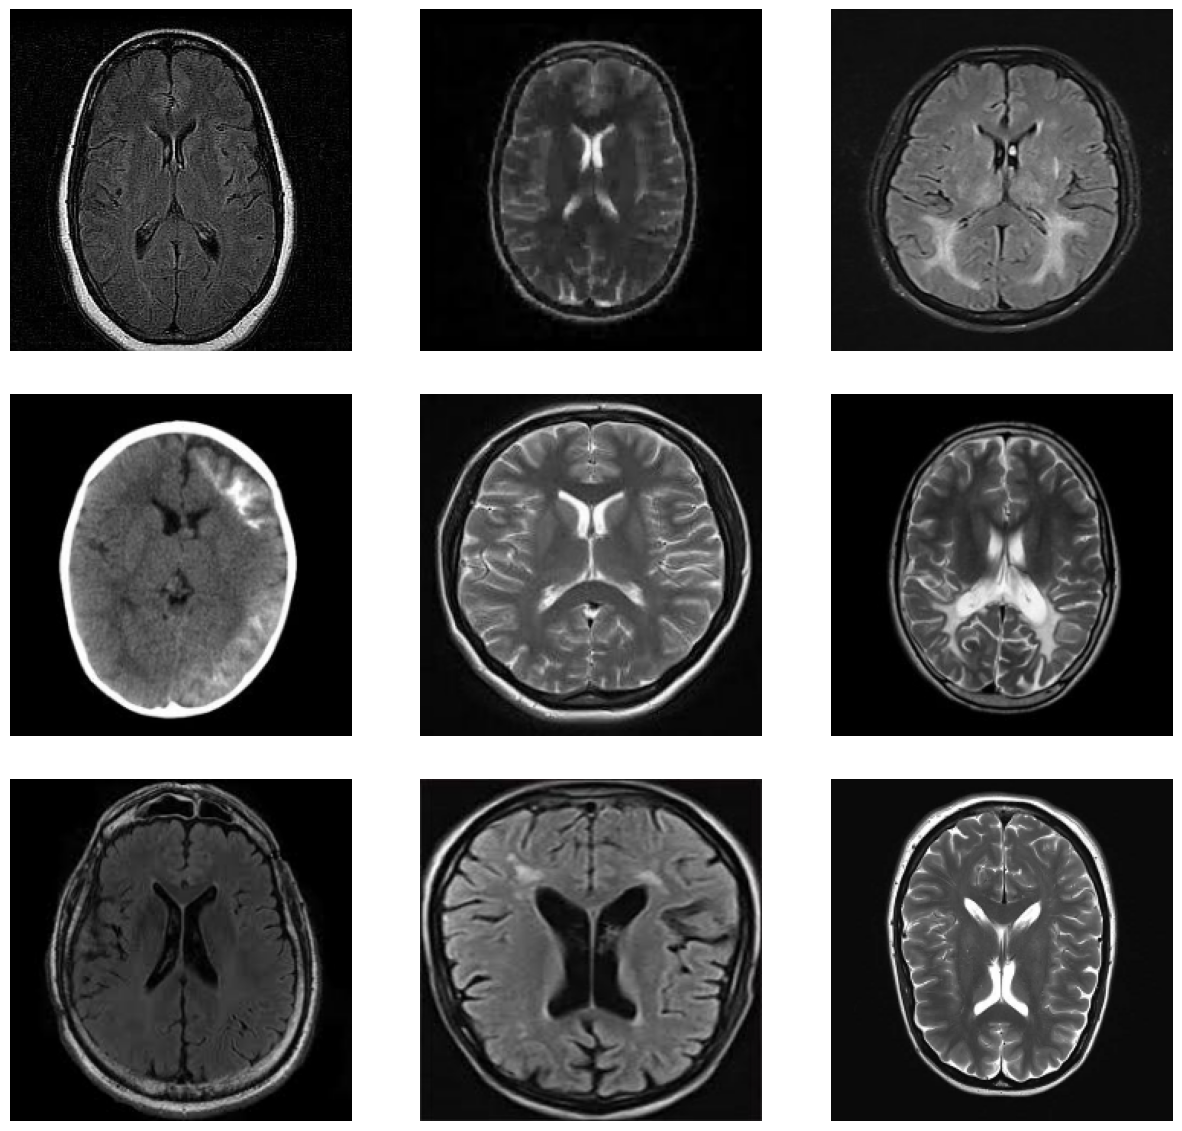

In [54]:
# display 9 random non tumor images
display_images_from_folder(nimg_dir, 9, 3, 3)

<Figure size 640x480 with 0 Axes>

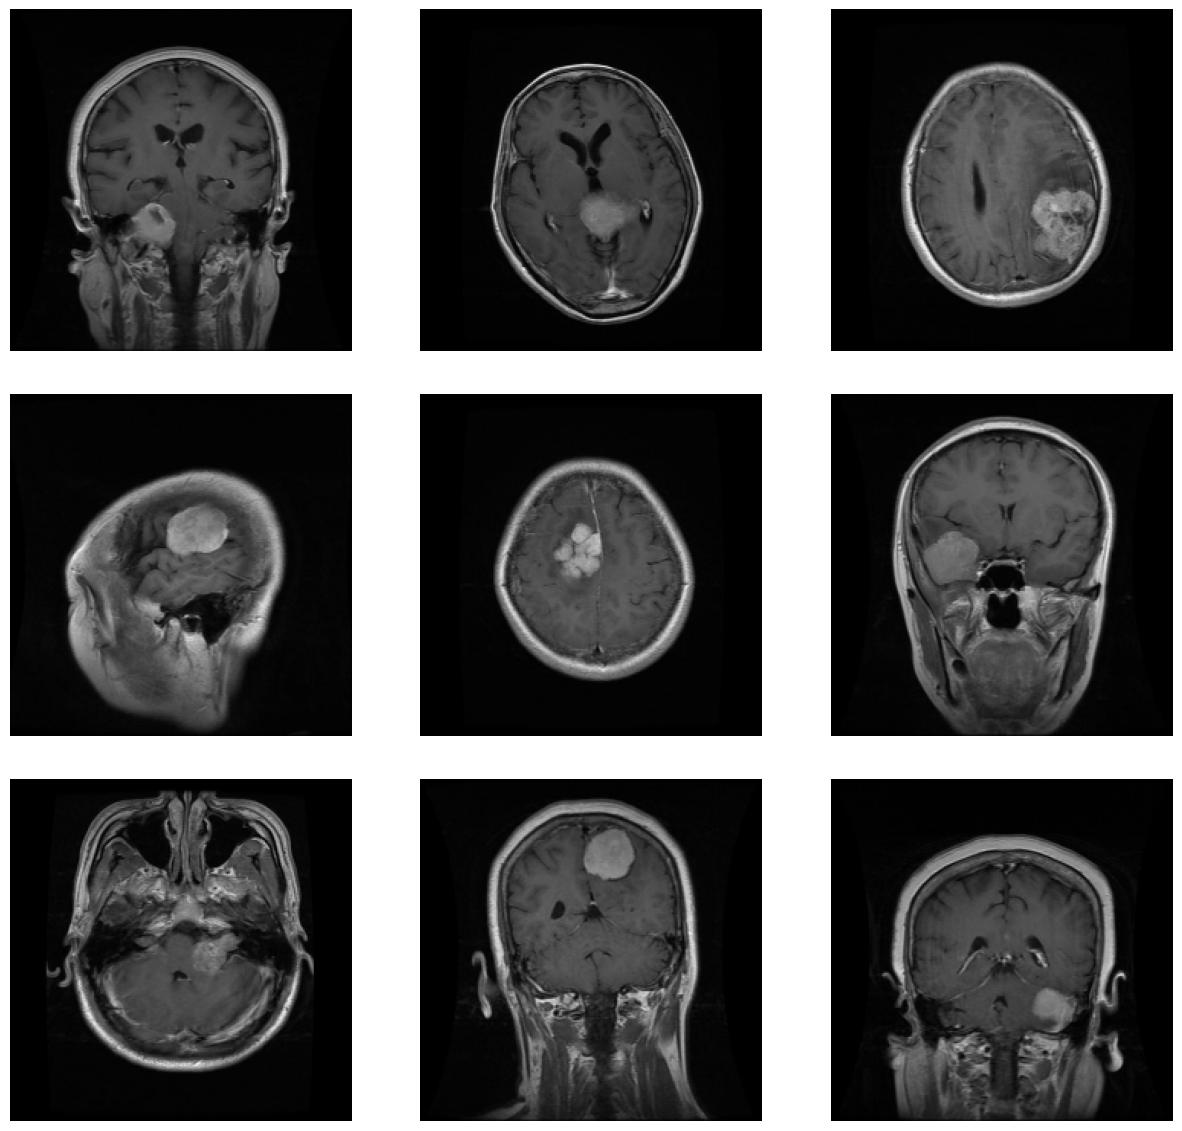

In [55]:
# 9 random tumor images
display_images_from_folder(timg_dir, 9, 3, 3)

### Image statistics

Calculate image statistis based on pixel values - mean, max, min, standard deviation, for mri images without and with tumor. Plot histogram of image intensities for MRI images with and without tumor

In [ ]:
def image_stats_single_image(image):
  """
  Calculates min, max, mean, and standard deviation of pixel values in an image.

  Args:
    image: A NumPy array representing the image.

  Returns:
    A dictionary containing the statistics: {'min': min_val, 'max': max_val, 'mean': mean_val, 'std': std_val}
  """
  min_val = np.min(image)
  max_val = np.max(image)
  mean_val = np.mean(image)
  std_val = np.std(image)

  return {'min': min_val, 'max': max_val, 'mean': mean_val, 'std': std_val}

def image_stats_directory(img_dir):
  """
  Calculates the average image statistics (min, max, mean, std) for all images in a directory.

  Args:
    img_dir: Path to the directory containing images.

  Returns:
    A dictionary containing the average statistics: {'min': avg_min, 'max': avg_max, 'mean': avg_mean, 'std': avg_std}
  """
  total_stats = {'min': 0, 'max': 0, 'mean': 0, 'std': 0}
  num_images = 0

  for filename in os.listdir(img_dir):
    # Check for common image extensions AND that filename does NOT contain null character
    if filename.endswith(('.jpg')) and '\0' not in filename:
      image_path = os.path.join(img_dir, filename)
      img = cv2.imread(image_path)

      # Call the specific image stats function to avoid recursion error
      stats = image_stats_single_image(img)


      # Accumulate statistics
      for key in total_stats:
        total_stats[key] += stats[key]
      num_images += 1

  # Calculate average statistics
  avg_stats = {}
  for key in total_stats:
    avg_stats[key] = total_stats[key] / num_images if num_images else 0  # Avoid division by zero

  return avg_stats

In [ ]:
# image statistics for tumor and non tumor images
print(f'Notumor images stats:\n{image_stats_directory(normal_fp)}')
print(f'Tumor images stats:\n{image_stats_directory(tumor_fp)}')

Notumor images stats:
{'min': 0.4244514106583072, 'max': 250.82006269592478, 'mean': 60.7336652067235, 'std': 60.56700777089741}
Tumor images stats:
{'min': 0.10007468259895444, 'max': 254.46153846153845, 'mean': 43.48210818260142, 'std': 46.73382587912519}


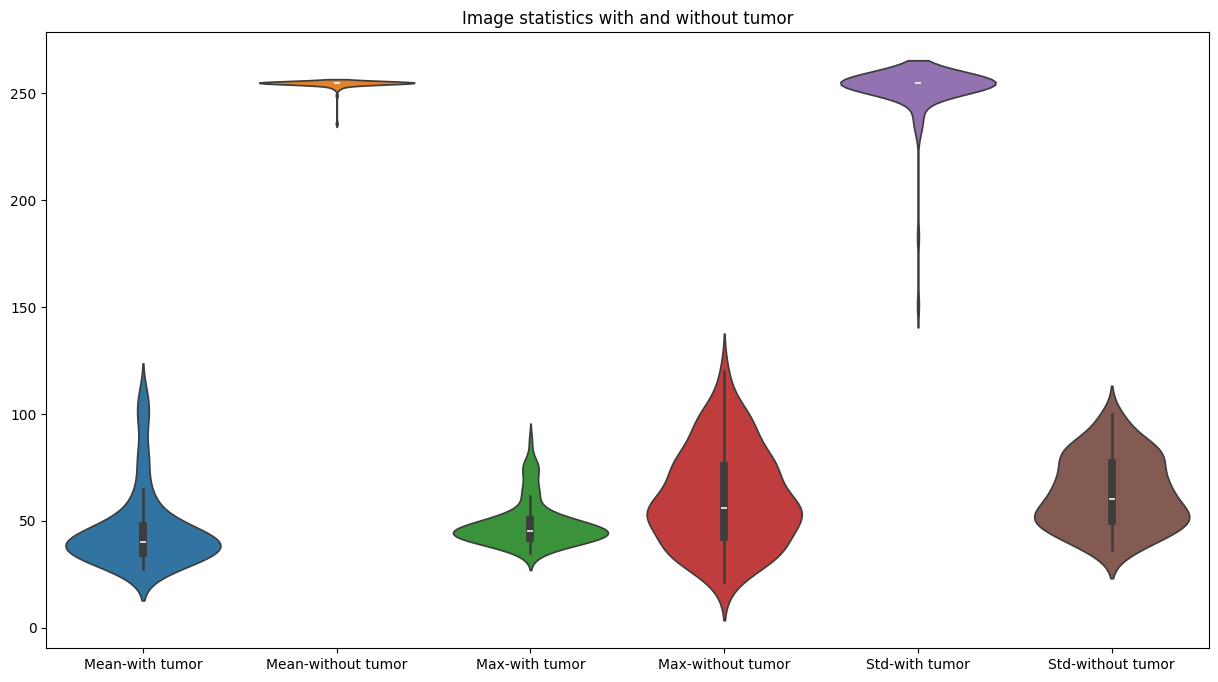

In [58]:
import random as r
from numpy import asarray
from PIL.ImageStat import Stat
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd

# Lists to store image statistics for tumor and non-tumor images
t_mean = []
t_max = []
t_std = []

n_mean = []
n_max = []
n_std = []

# Loop through 100 tumor images
for i in range(100):
    img = Image.open(timg_files[i])
    t_mean.append(np.mean(img))
    t_max.append(np.max(img))
    t_std.append(np.std(img))

# Loop through 100 non-tumor images
for i in range(100):
    img = Image.open(nimg_files[i])
    n_mean.append(np.mean(img))
    n_max.append(np.max(img))
    n_std.append(np.std(img))

# Create DataFrame from lists
df = pd.DataFrame(list(zip(t_mean, t_max, t_std, n_mean, n_max, n_std)),
                  columns=['Mean-with tumor', 'Mean-without tumor', 'Max-with tumor', 'Max-without tumor', 'Std-with tumor', 'Std-without tumor'])

# Create violin plot to compare image statistics for tumor and non-tumor images
plt.figure(figsize=(15, 8))
ax = sns.violinplot(data=df)
plt.title("Image statistics with and without tumor")
plt.show()

### Difference Statistical Significance

Conditionas for performance of t-test:

1. Normality: The data within each group being compared should approximately follow a normal distribution. This can be assessed visually using histograms or Q-Q plots, or formally tested using statistical tests like the Shapiro-Wilk test. However, t-tests are generally robust to moderate departures from normality, especially with larger sample sizes.

2. Independence: The observations within each group should be independent of each other. This means the value of one observation should not influence the value of another observation within the same group.

3. Equal Variances (for independent two-sample t-test): For the independent two-sample t-test, it is often assumed that the variances of the two groups being compared are equal. This can be assessed using statistical tests like Levene's test. If variances are significantly different, alternative t-tests like Welch's t-test can be used.

4. Random Sampling: Ideally, the data should be obtained through random sampling from the population of interest. This helps ensure that the sample is representative of the population and reduces bias.

In [ ]:
from scipy import stats

def compare_image_stats(folder1, folder2):
  """
  Performs a two-sample t-test to check for statistically significant differences in average image statistics between two folders.

  Args:
    folder1: Path to the first folder containing images.
    folder2: Path to the second folder containing images.

  Returns:
    A dictionary containing p-values for each statistic: {'min': p_min, 'max': p_max, 'mean': p_mean, 'std': p_std}
  """
  stats1 = image_stats_directory(folder1)  # Calculate average stats for folder1
  stats2 = image_stats_directory(folder2)  # Calculate average stats for folder2

  p_values = {}

  for key in stats1:
    # Perform independent two-sample t-test
    # Get all stats for the current key, filtering out invalid filenames
    group1_stats = get_all_stats_for_key(folder1, key)
    group2_stats = get_all_stats_for_key(folder2, key)

    # Check if both groups have data before performing t-test
    if group1_stats and group2_stats:
      _, p_value = stats.ttest_ind(group1_stats, group2_stats)
      p_values[key] = p_value
    else:
      p_values[key] = np.nan  # Assign NaN if one or both groups have no data

  return p_values


def get_all_stats_for_key(folder, key):
  """
  Helper function to extract a specific statistic for all images in a folder.

  Args:
    folder: Path to the folder containing images.
    key: The statistic to extract ('min', 'max', 'mean', or 'std').

  Returns:
    A list of the specified statistic for all images in the folder.
  """
  stats_list = []
  for filename in os.listdir(folder):
    # Filter out corupted filenames like ones starting with null characters
    if '\0' not in filename and filename.endswith(('.jpg')):
      image_path = os.path.join(folder, filename)
      img = cv2.imread(image_path)
      stats = image_stats_single_image(img) # Use image_stats_single_image to avoid recursion error
      stats_list.append(stats[key])
  return stats_list

p_values = compare_image_stats(normal_fp, tumor_fp)
print(p_values)

{'min': 0.0001526652806307527, 'max': 1.565672541882126e-17, 'mean': 8.710629748352264e-128, 'std': 2.7914440019053423e-160}


### Histogram of image intensities

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

def plot_flattened_histogram(image_path, image_name):
  """
  Plots the histogram of a 2D image flattened to 1D.

  Args:
    image_path: Path to the image file.
  """
  # Load the image in grayscale
  # Check if the file exists before attempting to read it
  if not os.path.exists(image_path):
    print(f"Error: Image file not found at: {image_path}")
    return  # Exit the function if the file doesn't exist

  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  # Check if the image was loaded successfully
  if img is None:
    print(f"Error: Could not load image from: {image_path}")
    return  # Exit the function if loading failed

  # Flatten the image to 1D
  flattened_img = img.flatten()

  # Calculate the histogram
  hist, bins = np.histogram(flattened_img, bins=256, range=[0, 256])

  return hist, bins[:-1]

In [ ]:
# get a random image in tumor_fp
random_idx = np.random.randint(0, len(os.listdir(normal_fp)))
notumor_img = tumor_fp + os.listdir(tumor_fp)[random_idx]

random_idx = np.random.randint(0, len(os.listdir(tumor_fp)))
tumor_img = tumor_fp + os.listdir(tumor_fp)[random_idx]


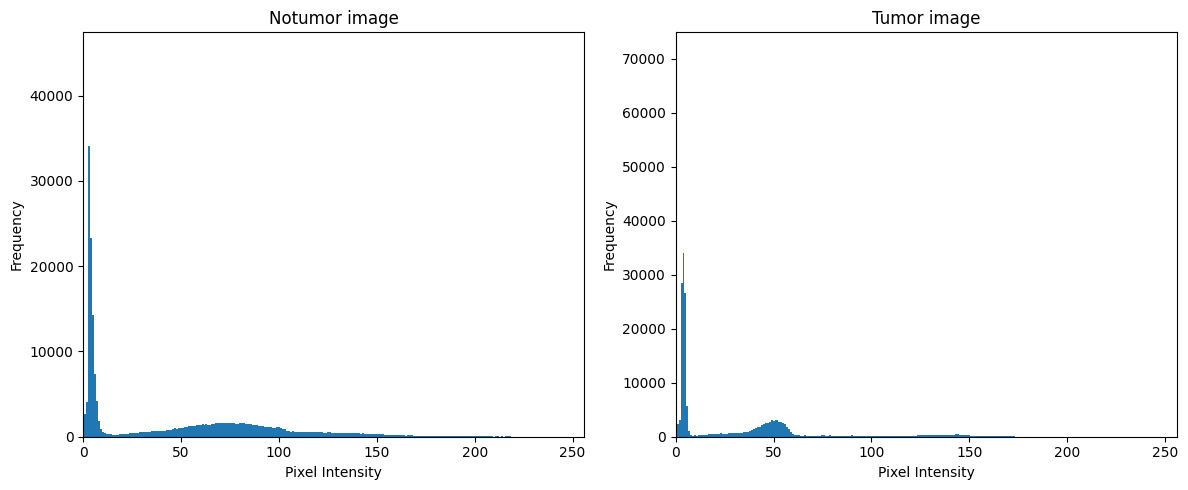

In [ ]:
# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histograms on the subplots
hist, bins = plot_flattened_histogram(notumor_img, "Notumor image")
ax1.bar(bins, hist, width=1)  # Use bar for histograms, not plot
ax1.set_title("Notumor image")
ax1.set_xlabel("Pixel Intensity")
ax1.set_ylabel("Frequency")
ax1.set_xlim([0, 256])

hist, bins = plot_flattened_histogram(tumor_img, "Tumor image")
ax2.bar(bins, hist, width=1)  # Use bar for histograms
ax2.set_title("Tumor image")
ax2.set_xlabel("Pixel Intensity")
ax2.set_ylabel("Frequency")
ax2.set_xlim([0, 256])

# Display the figure adjusting spacing between subplots
plt.tight_layout()
plt.show()

## 2. Image Enhancement

Enhance the contrast of an image by applying histogram equalization

Text(0.5, 1.0, 'Image after histogram equalization')

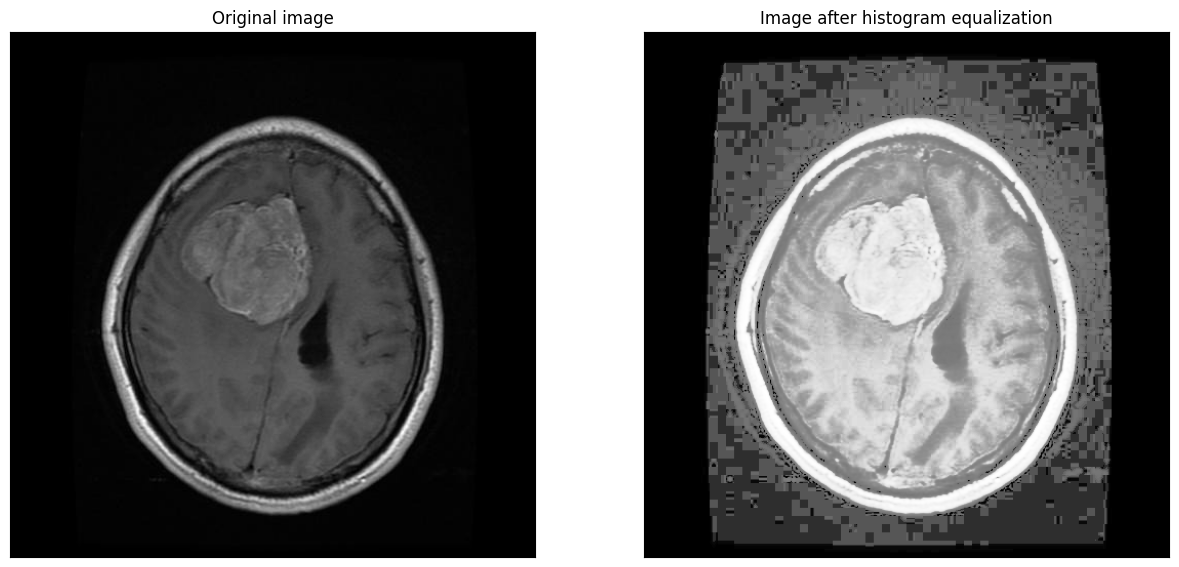

In [66]:
i= r.randint(0, len(timg_files))

img = cv2.imread(timg_files[i],cv2.IMREAD_GRAYSCALE)
#img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
hist_eq = cv2.equalizeHist(img)

hist_eq = cv2.cvtColor(hist_eq,cv2.COLOR_GRAY2RGB)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
# remove axis ticks
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(img, cmap= 'gray')
ax1.set_title('Original image')

ax2 = fig.add_subplot(222)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.imshow(hist_eq, cmap= 'gray')
ax2.set_title('Image after histogram equalization')

In [67]:
def equalize_image(image_path, target_value=0):
  """
  Enhance the contrast of MRI image with histogram equalization of the flatten image.
  """
  # read a image using imread
  img = cv2.imread(image_path, equ)

  # creating a Histograms Equalization of a image using cv2.equalizeHist()
  equ = cv2.equalizeHist(img)

  # stacking images side-by-side
  res = np.hstack((img, equ))

  # Window name in which image is displayed
  window_name = 'res'

  # show image input vs output
  cv2.imshow(window_name, res)

  cv2.waitKey(0)
  cv2.destroyAllWindows()

  return equ

In [68]:
def equalize_images(imgs_path, equ_imgs_path):
  """
  Enhance the contrast of MRI images with histogram equalization of the flatten
  images, saving the equalized images to a folder.
  """
  for img_name in os.listdir(imgs_path):
    img_path = os.path.join(imgs_path, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    equ_img = cv2.equalizeHist(img)
    equ_img_path = os.path.join(equ_imgs_path, img_name)
    #equ_img = equalize_image(img_path)
    cv2.imwrite(equ_img_path, equ_img)


In [ ]:
# create folders to hold enhanced images if do not exist
for folder in ["mri_data_full/train/normal_equ/", "mri_data_full/train/tumor_equ/"]:
  if not os.path.exists(folder):
    os.makedirs(folder)
    print(f"Folder {folder} created successfully.")
  else:
    print(f"Folder {folder} already exists.")


normal_equ_fp = "mri_data_full/train/normal_equ/"
tumor_equ_fp = "mri_data_full/train/tumor_equ/"

# equalize and save non-tumor and tumor histogram enhacned images
equalize_images(normal_fp, normal_equ_fp)
equalize_images(tumor_fp, tumor_equ_fp)

Folder mri_data_full/train/normal_equ/ already exists.
Folder mri_data_full/train/tumor_equ/ already exists.


## 3. Image Reconstruction with Phantom Image

Generate an Analytic MRI image phantom from which generate a frequency space representation of the phantom, apply blur in the frequency space using convolutions. From the prequency domain representation construct the phanotm image.

### Shepp-Logan Phantom

The **Shepp-Logan** phantom is a standard test image used in image processing and reconstruction of MRI and CT scans. It is a synthetic image that simulates the cross-section of a human head is used as a benchmark to:
- **Test Reconstruction Algorithms:** it helps in evaluating the performance of various image reconstruction algorithms. Since the phantom is a known image, any deviations in the reconstructed image can be identified and analyzed
- **Validate Image Quality:** it provides a standard reference to compare the quality of MRI images. It can be used to asses if imaging techniques produce accurate anatomy representation
- **Algorithm Development:** it aids in the development and fine-tuning of new algorithms for noise reduction, artifact removal, and other image enhancement techniques

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from phantominator import shepp_logan, mr_ellipsoid_parameters

In [70]:
# modify elipsoid parameters
E = mr_ellipsoid_parameters()
E[6, 3] = 0.2
E[6, 4] = 0.2
E[4, 1] = -0.1
E[8, 3] = 0.04
E[8, 4] = 0.04
E[9, 3] = 0.04
E[9, 4] = 0.04
E[11, 3] = 0.04
E[11, 4] = 0.04

In [71]:
# generate a syntetic 256x256 image that mimics the structure of a human head,
# z-limits define the region of interest within the phantom with resolution 256
N = 256
M0, T1, T2 = shepp_logan(
    (N, N, 1), MR=True, E=E, zlims=(-.25, -.25))
M0, T1, T2 = M0[..., 0], T1[..., 0], T2[..., 0]

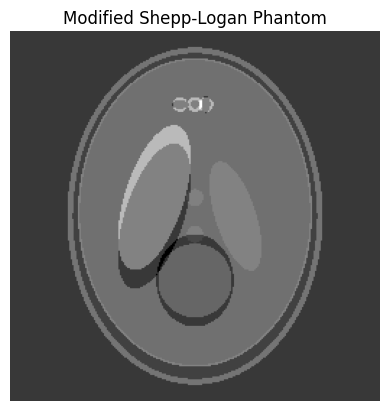

In [72]:
# display reconstructed phantom
plt.imshow(M0, cmap='gray')
plt.title('Modified Shepp-Logan Phantom')
plt.axis('off')
plt.show()

### Fourier Transform

The zero-frequency shift to the center is performed to make the Fourier transform more interpretable and visually meaningful. Here's a step-by-step explanation:

**Fourier Transform**
   - converts a spatial domain image into its frequency domain representation
   - in the frequency domain, the zero-frequency component represents the average intensity of the image and is typically located at the origin of the frequency spectrum

**Visualization**
   - when visualizing the frequency spectrum, having the zero-frequency component at the origin can make it difficult to interpret the higher frequency components, which are spread out around the edges
   - by shifting the zero-frequency component to the center of the spectrum, the low-frequency components, which contain most of the image's information are centered, and the high-frequency components are symmetrically distributed around it.

In [73]:
from scipy.fft import fftn, ifftn, fftshift, ifftshift

Use of scipy.fft module functions to accomplish contrast stretching

* fftn: Computes the N-dimensional discrete Fourier Transform
* ifftn: Computes the N-dimensional inverse discrete Fourier Transform
* fftshift: Shifts the zero-frequency component to the center of the spectrum
* ifftshift: Inverse of fftshift, shifts the zero-frequency component back to the original position

In [74]:
# apply fftshft to shift the zero-frequency component to the center, then
# compute the N-dimensional Fourier Transform  and then appliy ifftshift

# lambda function that performs FFT with zero-frequency shift to the center
mri_fft = lambda x: ifftshift(fftn(fftshift(x)))
# lambda function performs the inverse Fourier transform, reversing the shift
mri_ifft = lambda x: ifftshift(ifftn(fftshift(x)))

# FFT of the mri phantom to obtain its Fourier Transform known as k-space
k_space = mri_fft(M0)

# compute the magnitude spectrum of the k_space
k_mag = np.abs(k_space)
# apply a logarithmic scale to enhance the visibility of the Forurier Transform
# by converting into a decibel scale
k_mag = 20 * np.log10(k_mag)

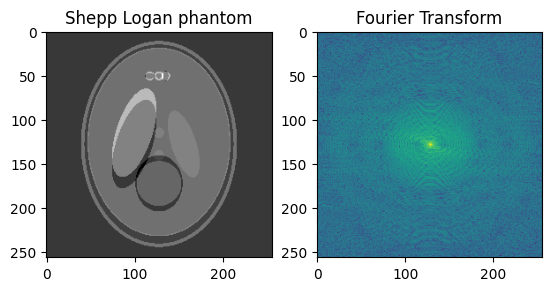

In [76]:
# display the original image in gray scale and the enchanced FT image in viridis colormap
plt.subplot(121), plt.imshow(M0, cmap='gray')
plt.title("Shepp Logan phantom")
plt.subplot(122), plt.imshow(k_mag, cmap='viridis')
plt.title("Fourier Transform")
plt.show()

### Blurring with Gaussian Filter

Blurring is used for
* **Noise Reduction** it helps reduce high-frequency component, which often corresponds to noise and applying a Gaussian filter smooths these variations
* **Feature Extraction** blurring an image can emphasize larger structures and features while supressing smaller, less significant details
* **Frequency Domain Filtering**: where blurring corresponds to attenuating high-frequency componenets and so helps mitigate artifacts and enhance overall quality of reconstructed image
* **Prepocessing** by smoothing out irregularities

In [ ]:
# build and apply Gaussian filter blurmask to the image in the frequency domain
ncols, nrows = 256, 256
sigx, sigy = 10, 10 # standart deviation
cy, cx = nrows/2, ncols/2
x = np.linspace(0, nrows, nrows)
y = np.linspace(0, ncols, ncols)
X, Y = np.meshgrid(x, y)
# Gaussian filter
blurmask = np.exp(-(((X-cx)/sigx)**2 + ((Y-cy)/sigy)**2))
# apply Gaussing filter in frequency domain
ftimagep = k_space * blurmask

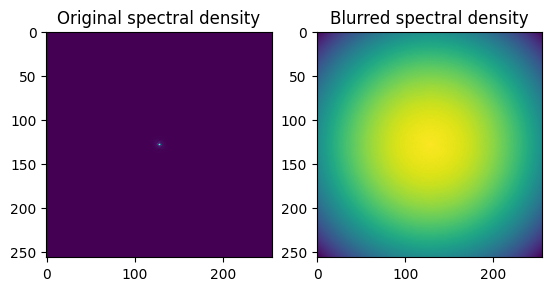

In [ ]:
#plot power spectrum before and after blurring
mag_blur = 20*np.log(np.abs(ftimagep))

plt.subplot(121), plt.imshow(np.abs(ftimagep))
plt.title("Original spectral density")
plt.subplot(122), plt.imshow(mag_blur, cmap='viridis')
plt.title("Blurred spectral density")
plt.show()

### Image Reconstruction

Image Reconstruction:

1. **K-Space Data**:
   - the raw data collected is in the frequency domain which represents the spatial frequencies of the image.

2. **Inverse Fourier Transform**:
   - to reconstruct the image from k-space, an inverse Fourier transform is applied. This process converts the frequency information back into spatial information, producing an image that can be visualized.

3. **Magnitude Calculation**:
   - The result of the inverse Fourier transform is often a complex number. The magnitude of this complex number represents the intensity of the image at each point.

4. **Image Conversion and Display**:
   - The magnitude data is converted into an image format and displayed using plotting libraries like Matplotlib

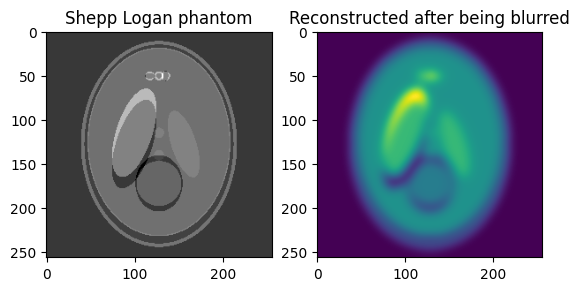

In [ ]:
# take inverse of Fast Fourier Transformed image which converts the frequency
# domain data back into the special domain
imagep = mri_ifft(ftimagep)
# reconstruct the image
res = Image.fromarray(abs(imagep))
plt.subplot(121), plt.imshow(M0, cmap='gray')
plt.title("Shepp Logan phantom")
plt.subplot(122), plt.imshow(np.abs(res))
plt.title("Reconstructed after being blurred")
plt.show()